In [2]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

from numpy import pi, sqrt, log, sin, cos, exp
from numpy.random import rand

np.seterr(divide="ignore", invalid="ignore")

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

1. $p_i$ conjugate to $x_i$ ← 𝒩
2. MD: $x_i(τ)$ and $p_i(τ)$ ← leap frog
- τ: 0 ... $τ_{fin}$ 
$$ H({x},{p})=S({x}) + 0.5∑_i p_i^2 \tag{5.1} $$
3. $H_{init}(τ=0)$ and $H_{fin}(τ_{fin})$.
4. MetroTest: $x_i^{k+1}=[min(1,exp[H_{init}-H_{fin}])]:x_i(τ_{fin}):x_i^k$

# HMC Algo

1. $ x_i(Δτ/2) = x_i(0) + p_i(0)⋅Δτ/2 $
2. for $n=1...N_τ-1$:
- $ p_i(nΔτ) = p_i((n-1)Δτ)-∂S_{x_i}((n-1)Δτ)⋅Δτ $
- $ x_i((n+1/2)Δτ) = x_i((n-1/2)Δτ) + p_i(nΔτ)⋅Δτ $
3. finally:
- $ p_i(N_τ Δτ) = p_i((N_τ-1)Δτ) - ∂S_{x_i}((N_τ-1/2)Δτ)⋅Δτ $
- $ x_i(N_τ Δτ) = x_i((N_τ-1/2) Δτ)    + p_i(N_τ Δτ)⋅Δτ/2 $


0.98458


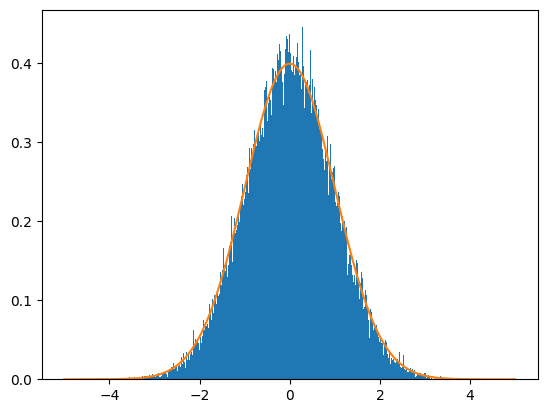

In [3]:
K = 100_000
n_tau = 10
d_tau = 0.1

# box_miller
R = rand(K)
S = rand(K)
P = sqrt(-2 * log(R)) * sin(2 * pi * S)
Q = sqrt(-2 * log(R)) * cos(2 * pi * S)


@njit
def action(x):
    return 0.5 * x**2


@njit
def hamil(x, p):
    return action(x) + 0.5 * p**2


@njit
def del_h(x):
    return x


@njit
def MD(k, x):
    p = P[k]
    init = hamil(x, p)

    x = x + p * 0.5 * d_tau

    for _ in range(n_tau):
        _del_h = del_h(x)
        p = p - _del_h * d_tau
        x = x + p * d_tau

    _del_h = del_h(x)
    p = p - _del_h * d_tau
    x = x + p * d_tau

    fin = hamil(x, p)
    return x, init, fin


@njit
def main():
    X = np.full(K, np.nan)
    A = np.full(K, False) # Accept
    M = rand(K) # Metropolis

    X[0] = 0

    for k in range(1, K):
        X[k], init, fin = MD(k, X[k - 1])
        A[k] = exp(init - fin) > M[k]
        X[k] = X[k] if A[k] else X[k - 1]

    return X, A


X, A = main()

##################################################

plt.hist(X, 1_000, density=True)

x = np.linspace(-5, 5, 1000)
y = 1.0 / np.sqrt(2.0 * np.pi) * np.exp(-x * x / 2.0)
plt.plot(x, y)

print(A.sum() / K)

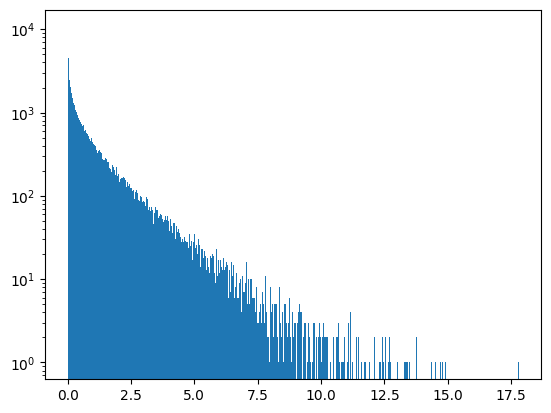

In [4]:
plt.hist(X**2, 1000)
plt.yscale("log");